## Convolutional Neural Networks, and Large Scale Visual Recognition Project (20 pts)
## Nikhil Bhaip (nb5hd)
<em>University of Virginia - Introduction to Computer Vision - Spring 2018 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this project assignment we will apply our knowledge of machine learning and visual recognition using convolutional neural networks to detect various kinds of things from images. We will start from our already familiar CIFAR-10 dataset and we will end up building a more open-ended application.

### 1. Pytorch on the GPU (2pts)
In this section we will experiment with GPU computations and how they speed up some computations under certain conditions.

#### 1.1 Pytorch Installation and GPU Environment Setup (0pts)
We will need to install again pytorch but this time make sure you connect to a GPU enabled machine because a convolutional neural network is very slow on a CPU. Pytorch supports GPU computations for free by using the .cuda() method for tensors and modules. You need to do Runtime -> Change Runtime Type before you run the code below to make sure you are using a machine from Google Cloud that has GPU. Feel free to use your own machine if you have a CUDA-enabled device installed locally.

In [0]:
!pip install --upgrade pip

# !pip install torch
!pip install torchvision
!pip3 install http://www.cs.virginia.edu/~vicente/vision/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install --no-cache-dir -I pillow
!pip3 install tqdm
!wget -nc https://www.cs.virginia.edu/~vicente/vision/cifar-10-python.tar.gz -P datalab
!tar xf datalab/cifar-10-python.tar.gz -C datalab
!wget -nc http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
!pip3 install Pillow==4.0.0
!pip3 install PIL
!pip3 install image

!pip3 install Cython
!if cd cocoapi; then git pull; else git clone https://github.com/cocodataset/cocoapi.git; fi
!make -C cocoapi/PythonAPI
!pip3 install pycocotools
!pip3 install tqdm

  


#### 1.2 GPU Environment Testing (2pts)
Now we are going to test the GPU environment in a task of multiplying two square matrices of size $d\times d$. We provide code below sample code and output for this part but you need to complete the test below.

In [3]:
# !pip install torch
import torch
import time

# Let's create two matrices of size 4x4 and full of ones.
d = 5000
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a dot product between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a dot product between the two matrices in GPU.
start_time = time.time()
a = a.cuda() # Move to GPU.
b = b.cuda() # Move to GPU.
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))

CPU-time 3.430562s
GPU-time 0.030027s

CPU was 114.25x times the GPU time


Produce a plot using matplotlib that shows the execution time (y-axis) versus the size $d$ of the square matrices (x-axis) for both GPU and CPU (use values of $d$ = [10, 100, 1000, 5000, 10000]). Answer the following question: For what values of $d$ would you recommend using a GPU?

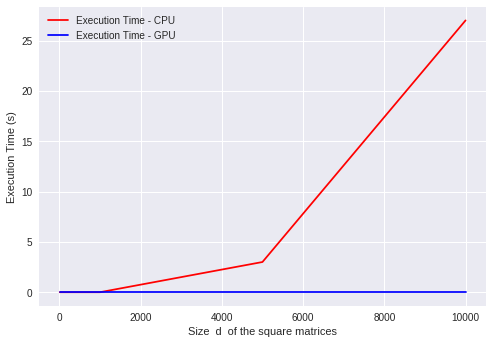

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Your plotting code goes here.

d_vals = np.array([10, 100, 1000, 5000, 10000])
exec_time_cpu = np.zeros_like(d_vals)
exec_time_gpu = np.zeros_like(d_vals)

for i, d in enumerate(d_vals):
  d = int(d)
  a = torch.rand(d, d)
  b = torch.rand(d, d)

  # Compute a dot product between the two matrices in CPU.
  start_time = time.time()
  output = torch.mm(a,b)  # Regular multiplication in CPU.
  exec_time_cpu[i] = time.time() - start_time

  # Compute a dot product between the two matrices in GPU.
  start_time = time.time()
  a = a.cuda() # Move to GPU.
  b = b.cuda() # Move to GPU.
  output = torch.mm(a,b)  # Multiplication happens in GPU.
  exec_time_gpu[i] = time.time() - start_time
 
plt.plot(d_vals, exec_time_cpu, color='r', label='Execution Time - CPU')
plt.plot(d_vals, exec_time_gpu, color='b', label='Execution Time - GPU')
plt.ylabel('Execution Time (s)')
plt.xlabel('Size  d  of the square matrices')
plt.legend()
plt.show()
  

***I would recommend using a GPU for value of d greater than 1000. ***

**Final Comments:** In the GPU code there is a more or less fixed cost of moving tensors to the GPU, this causes using GPUs slower for small tensors counter-productive. Try timing this separately and estimate the cost of this move. Most functions in pytorch have a CUDA implementation so just by moving tensors to the GPU using .cuda() you can perform any operation in a highly parallel manner on a GPU. Moreover, Pytorch supports parallelization on multiple GPUs as well.<br/><br/>

### 2. Convolutional Neural Networks (CIFAR-10 Dataset) (4pts)
This section will build on the previous project but now we will use a convolutional neural network to obtain higher accuracies.

#### 2.1 CIFAR-10 Data Loading (0pts). 
In this section we will load the CIFAR-10 dataset, a dataset with 50 thousand training images of size 3x32x32 each belonging to one out of 10 possible categories of objects. First, let's download a local copy from the CS server.

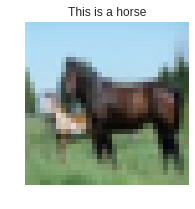

In [2]:
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt


# This is a convenient data reader.
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
train_data = datasets.CIFAR10('./datalab', train = True)

# This samples the 12-th image from the dataset.
# Try changing the index below to see different images in the dataset.
image, category = train_data[12]

# Display the image and its label.
plt.figure(figsize=(3,3))
plt.title('This is a %s' % categories[category])
plt.imshow(image); plt.grid('off');plt.axis('off')
plt.show()

#### 2.3 Convolutional Neural Network classifier (2pts)
In this section, you will define a convolutional neural network classifier and compute the accuracy of the model on CIFAR-10. Feel free to create any network that you consider would work well. You can get inspiration in some of the convolutional neural network architectures studied in class. I recommend you start with the LeNet architecture included below and start from there.

In [0]:
# Defining the model.
from tqdm import tqdm as tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


learningRate = 1e-2  # Single learning rate for this lab.

# NikhilNet is a slight variation of LeNet classifier
class NikhilNet(nn.Module):
    def __init__(self):
        super(NikhilNet, self).__init__()
        
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.conv2 = nn.Conv2d(9, 32, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(32*5*5, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
#         print(x.shape)
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Another linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)
       
        # We will not add nn.LogSoftmax here because nn.CrossEntropy has it.
        # Read the documentation for nn.CrossEntropy.
        
        return out
        
        
# Definition of our network.
classifier = NikhilNet().cuda()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
# This optimizer has access to all the parameters in the model.
#
# It can zero all the parameters by doing:
#                                  optimizer.zero_grad()
#
# It can perform an SGD optimization update step in the direction of
# the gradients for each parameters by doing:
#                                  optimizer.step()
#
optimizer = optim.SGD(classifier.parameters(), lr = learningRate)



#### 2.4 Training the CNN model (2pts)
Train your proposed CNN model and compute the accuracy. Plot the loss for training and validation as training progresses (same as in previous assignment), and the accuracy for training and validation (same as in previous assignment). What is the final accuracy? Hints: Remember to use classifier.train() classifier.eval(), also remember to normalize the input data.

In [5]:
from torch.autograd import Variable
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np

def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):
  # Your code goes here.
  
  train_loss = np.zeros((n_epochs))
  train_acc = np.zeros((n_epochs))
  test_loss = np.zeros((n_epochs))
  test_acc = np.zeros((n_epochs))
  
  
  for epoch in range(0, n_epochs):
  
    correct = 0
    cumloss = 0
    # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
      classifier.train()
      # Flatten the images in the batch to input to the classifier.
      x = Variable(x.cuda())
      y = Variable(y.cuda())

      # Compute predictions under the current model.
      yhat = classifier(x)

      # Compute the loss with respect to this batch.
      loss = criterion(yhat, y)
      _, max_labels = yhat.data.max(1)
      correct += (max_labels == y.data).sum()

      # Set to zero gradients computed in previous iteration.
      optimizer.zero_grad()

      # Compute the gradients for the entire model variables,
      # this includes inputs, outputs, and parameters (weight, and bias).
      loss.backward()

      # Now we can update the weight and bias parameters.
      optimizer.step()

      # if i % 50 == 0: print(epoch, i, loss.data[0])
      cumloss += loss.data[0]

    print(epoch, 'training-loss: ', cumloss / 50000)
    print(epoch, 'training-accuracy: ', correct / 50000)
    train_loss[epoch] = cumloss / 50000
    train_acc[epoch] = correct / 50000

    correct = 0
    cumloss = 0

    classifier.eval()
    # Compute accuracy on the test set.
    for (i, (x, y)) in enumerate(valLoader):
      # Flatten the images in the batch to input to the classifier.
      x = Variable(x.cuda(), requires_grad = False)
      y = Variable(y.cuda(), requires_grad = False)

      # Compute predictions under the current model.
      yhat = classifier(x)
      loss = criterion(yhat, y)
  
      _, max_labels = yhat.data.max(1)
      correct += (max_labels == y.data).sum()
      cumloss += loss.data[0]
    test_loss[epoch] = cumloss / 10000
    test_acc[epoch] = correct / 10000

    print(epoch, 'validation-loss: ', cumloss / 10000)
    print(epoch, 'validation-accuracy: ', correct / 10000)
    print('\n')
  return train_loss, train_acc, test_loss, test_acc

preprocess = transforms.Compose([
    transforms.ToTensor(),
    # This centers the data around zero, and scales the values
    # so that they have unit variance. 
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])





# # It is possible to pass the transformation function to the data wrappers,
# # so that train_data[0] returns a pytorch tensor and a label.
train_data = datasets.CIFAR10(root='./datalab', train = True, transform = preprocess)
validation_data = datasets.CIFAR10(root='./datalab', train = False, transform = preprocess)
batch_size = 128 
trainLoader = DataLoader(train_data, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(validation_data, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)


train_loss, train_acc, test_loss, test_acc = train_model(classifier, criterion, optimizer, 
            trainLoader, valLoader, n_epochs = 10)

print("Final test accuracy is:", test_acc[-1])

0 training-loss:  0.0177618883228302
0 training-accuracy:  0.14384
0 validation-loss:  0.017257290649414062
0 validation-accuracy:  0.2324


1 training-loss:  0.015844599132537843
1 training-accuracy:  0.27324
1 validation-loss:  0.014864044177532195
1 validation-accuracy:  0.3276


2 training-loss:  0.013976868999004364
2 training-accuracy:  0.35522
2 validation-loss:  0.013325323128700257
2 validation-accuracy:  0.3888


3 training-loss:  0.012956969611644744
3 training-accuracy:  0.39902
3 validation-loss:  0.012695569789409637
3 validation-accuracy:  0.4176


4 training-loss:  0.012272825775146485
4 training-accuracy:  0.43154
4 validation-loss:  0.012013077211380004
4 validation-accuracy:  0.4484


5 training-loss:  0.011738340401649476
5 training-accuracy:  0.46086
5 validation-loss:  0.01187199809551239
5 validation-accuracy:  0.4531


6 training-loss:  0.011298368511199952
6 training-accuracy:  0.48222
6 validation-loss:  0.011632667911052703
6 validation-accuracy:  0.4724


7 

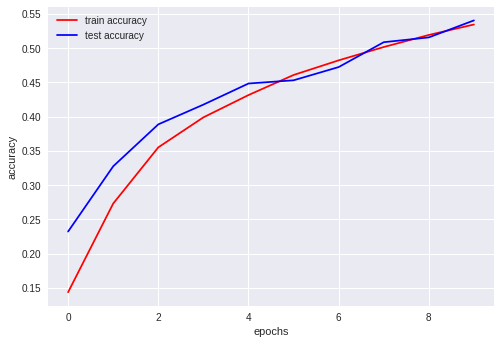

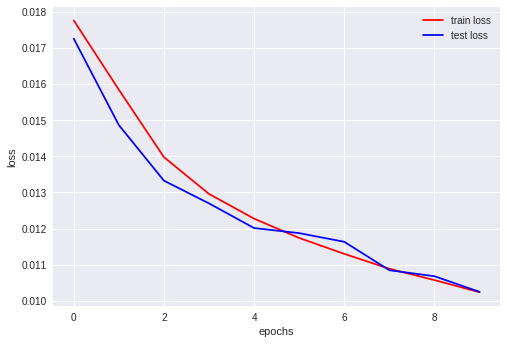

In [6]:
epochs = np.arange(10)
plt.plot(epochs, train_acc, color='r', label='train accuracy')
plt.plot(epochs, test_acc, color='b', label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.plot(epochs, train_loss, color='r', label='train loss')
plt.plot(epochs, test_loss, color='b', label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


**Final Comments:** You should get a much better classification accuracy of this model. Try running it in some validation images and see how much better are the predictions of this model compared to the one used in a previous assignment.

### 3. Convolutional Neural Networks (COCO Dataset) (8pts)
In this section we will use a state-of-the-art deep neural network trained on the ILSVRC (Imagenet Large Scale Visual Recognition Challenge) dataset, and "fine-tune" the weights of this network to learn a network that can detect the 80 objects in the COCO Dataset.

#### 3.1 Pre-trained ResNet-50 CNN (0pts)
In this section we will experiment with a ResNet network with 50 layers of depth as seen during class. This network was trained in the ILSVRC task where it was trained on a million images each with one label belonging to 1000 possible classes. First let's load the pre-trained model and categories vocabulary.

In [0]:
# !wget -nc http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json

import torchvision.models as models

# Load the pre-trained model from the torchvision package.
resnet = models.resnet50(pretrained = True);
resnet.eval();  # Set in evaluation mode! In this case it matters.

Now let's run an image through the network. Pay careful attention to all the steps.

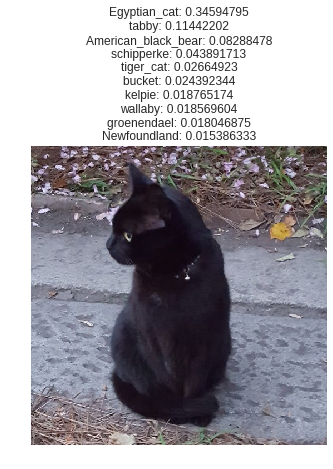

In [3]:

import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}


# 3. Read image from URL into a PIL image type.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  torch.autograd.Variable(preprocessFn(img_pil).unsqueeze(0))
predictions = resnet(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]
indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

#### 3.2 Experiment with ResNet (2pts)
Take pictures of two objects for which the ResNet network works really well and show the predictions, do the same for two objects for which the network doesn't do well. Take your own pictures of objects at your place, don't download images from the internet.

Accurate. Predicts pill bottle with high confidence
Accurate. Predicts running shoe with high confidence
Inaccurate. Predicts packet instead of umbrella with high confidence
Inaccurate. Predicts stethoscope instead of sunglasses with high confidence


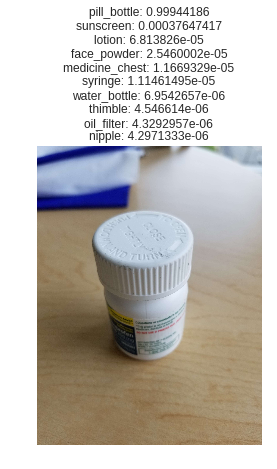

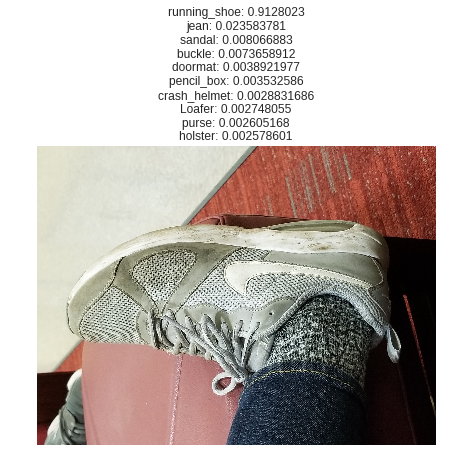

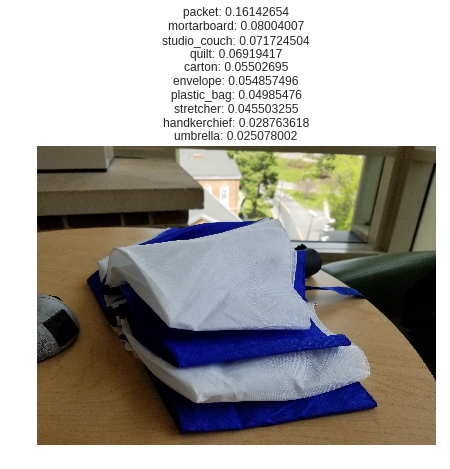

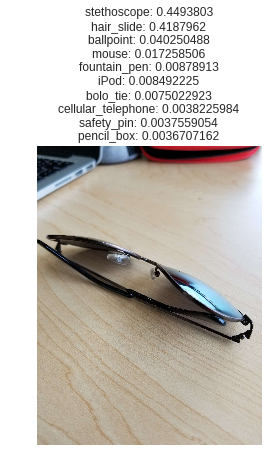

In [9]:
def predict_img(img_url):
  response = requests.get(img_url)
  img_pil = Image.open(io.BytesIO(response.content))

  # 4. Forward propagate the image through the CNN.
  # Unsqueeze adds a dummy batch dimension needed to pass through the model.
  inputVar =  torch.autograd.Variable(preprocessFn(img_pil).unsqueeze(0))
  predictions = resnet(inputVar)

  # 5. Decode the top 10 classes predicted for this image.
  # We need to apply softmax because the model outputs the last linear layer
  # outputs and not softmax scores.
  probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
  probs = (-probs).numpy()[0][:10]
  indices = indices.numpy()[0][:10]
  preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

  # 6. Show image and predictions
  plt.figure()
  plt.title('\n'.join(preds))
  plt.imshow(img_pil); plt.grid('off'); plt.axis('off');
print("Accurate. Predicts pill bottle with high confidence")
predict_img("https://raw.githubusercontent.com/nb5hd/computer_vision/master/pill_bottle.jpg")
print("Accurate. Predicts running shoe with high confidence")
predict_img("https://raw.githubusercontent.com/nb5hd/computer_vision/master/shoe.jpg")
print("Inaccurate. Predicts packet instead of umbrella with high confidence")
predict_img("https://raw.githubusercontent.com/nb5hd/computer_vision/master/umbrella.jpg")
print("Inaccurate. Predicts stethoscope instead of sunglasses with high confidence")
predict_img("https://raw.githubusercontent.com/nb5hd/computer_vision/master/sunglasses.jpg")




#### 3.3 Fine-tuning ResNet to the COCO-Dataset 80-category dataset (6pts)
The COCO (Common Objects in Context) Dataset has 80 object categories. You can browse it here http://cocodataset.org/#home. This dataset also has bounding box annotations but we will not use them in this project. You will only map each image to an 80-dimensional vector where each entry corresponds to an object type, where the value is 1 if the object-type is present and 0 otherwise. (i.e. will not use box annotations, or not use the number of objects of each type). **Hints:** (1) To build the dataloader for COCO you can reuse the dataloder in pytorch for COCO but you need to modify it to return an 80-dimensional vector as label http://pytorch.org/docs/master/torchvision/datasets.html#coco (2) The 80-category prediction will require a different loss since these labels are not mutually exclusive, you will have to use torch.nn.BCEWithLogitsLoss. **Note:** For speed and in order to reduce network overhead use only 20,000 images for training, and 1,000 images for validation.

In [0]:
# Download COCO-Dataset.
!wget -nc http://images.cocodataset.org/zips/train2017.zip -P coco/train
!unzip -o coco/train/train2017.zip
  !wget -nc http://images.cocodataset.org/zips/val2017.zip -P coco/val
!unzip -o coco/val/val2017.zip
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P coco/annotations
!unzip -o coco/annotations/annotations_trainval2017.zip


In [0]:
from pycocotools.coco import COCO
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader


coco = COCO('./annotations/instances_train2017.json')
cat_ids = coco.getCatIds()
cat_dictionary = {cat_id: index for index, cat_id in enumerate(cat_ids)}
  
def preprocess_annot(annotation, cat_dict=cat_dictionary):
  num_categs = len(annotation)
  
  eighty_dim_vect = np.zeros(80)
  
  if num_categs <= 0:
    return eighty_dim_vect
  
  all_categ_ids = np.array([cat_dict[cat['category_id']] for cat in annotation])
  
  eighty_dim_vect[all_categ_ids] = 1
  return eighty_dim_vect
  
preprocess_fn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

  
train_data = datasets.CocoDetection('./train2017/',
           './annotations/instances_train2017.json', transform=preprocess_fn, target_transform=preprocess_annot)

validation_data = datasets.CocoDetection('./val2017/',
           './annotations/instances_val2017.json', transform=preprocess_fn, target_transform=preprocess_annot)
batch_size = 100

trainLoader = DataLoader(train_data, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(validation_data, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)



In [0]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms


resnet = models.resnet50(pretrained = True);
resnet.train(); 

for param in resnet.parameters():
    param.requires_grad = False

# add final layer to go to 80
resnet.fc = nn.Linear(512*4, 80)
resnet = resnet.cuda()


# Optimize only the classifier
optimizer = optim.SGD(resnet.fc.parameters(), lr=1e-2)
criterion = nn.BCEWithLogitsLoss()

In [0]:
from torch.autograd import Variable
from torchvision import models, transforms
from torch.utils.data import DataLoader


def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):
  # Your code goes here.
  
  train_loss = np.zeros((n_epochs))
  train_acc = np.zeros((n_epochs))
  test_loss = np.zeros((n_epochs))
  test_acc = np.zeros((n_epochs))
  
  
  for epoch in range(0, n_epochs):
  
    correct = 0
    cumloss = 0
    classifier.train()
    # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
      
      x = Variable(x.cuda())
      y = Variable(y.cuda()).float()
      
      # Compute predictions under the current model.
      yhat = classifier(x)

      # Compute the loss with respect to this batch.
      loss = criterion(yhat, y)

      # max_label is index of max score for all 100 y-hat values in the batch
      _, max_label = yhat.data.max(1)
      
    # Count top 1 accuracy. 
      correct += (y.data.gather(1, max_label.view(-1,1)) ==1 ).sum()

      # Set to zero gradients computed in previous iteration.
      optimizer.zero_grad()

      # Compute the gradients for the entire model variables,
      # this includes inputs, outputs, and parameters (weight, and bias).
      loss.backward()

      # Now we can update the weight and bias parameters.
      optimizer.step()

      cumloss += loss.data[0]
      
      if i>=200:
        break

    print(epoch, 'training-loss: ', cumloss / 20000)
    print(epoch, 'training-accuracy: ', correct / 20000)
    train_loss[epoch] = cumloss / 20000
    train_acc[epoch] = correct / 20000

    correct = 0
    cumloss = 0

    classifier.eval()
    # Compute accuracy on the test set.
    for (i, (x, y)) in enumerate(valLoader):
      
      x = Variable(x.cuda(), requires_grad = False)
      y = Variable(y.cuda(), requires_grad = False).float()

      yhat = classifier(x)
      loss = criterion(yhat, y)
  
      _, max_labels = yhat.data.max(1)
      
      correct +=  (y.data.gather(1, max_label.view(-1,1)) ==1 ).sum()
      cumloss += loss.data[0]
      
      if i>=10:
        break
      
    test_loss[epoch] = cumloss / 1000
    test_acc[epoch] = correct / 1000

    print(epoch, 'validation-loss: ', cumloss / 1000)
    print(epoch, 'validation-accuracy: ', correct / 1000)
    print('\n')
  return train_loss, train_acc, test_loss, test_acc

In [23]:
train_loss, train_acc, test_loss, test_acc = train_model(resnet, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)

0 training-loss:  0.0031400297343730926
0 training-accuracy:  0.44735
0 validation-loss:  0.0020920148342847824
0 validation-accuracy:  0.584


1 training-loss:  0.0016629532106220723
1 training-accuracy:  0.54555
1 validation-loss:  0.0017087249159812928
1 validation-accuracy:  0.584


2 training-loss:  0.001472003487497568
2 training-accuracy:  0.54625
2 validation-loss:  0.0015874103605747222
2 validation-accuracy:  0.584


3 training-loss:  0.0013925279639661313
3 training-accuracy:  0.5414
3 validation-loss:  0.0015300511568784713
3 validation-accuracy:  0.584


4 training-loss:  0.0013553979322314263
4 training-accuracy:  0.53945
4 validation-loss:  0.001493976354598999
4 validation-accuracy:  0.584


5 training-loss:  0.001324960058927536
5 training-accuracy:  0.5456
5 validation-loss:  0.001465695582330227
5 validation-accuracy:  0.584


6 training-loss:  0.001311287885159254
6 training-accuracy:  0.54065
6 validation-loss:  0.0014485155567526818
6 validation-accuracy:  0.584



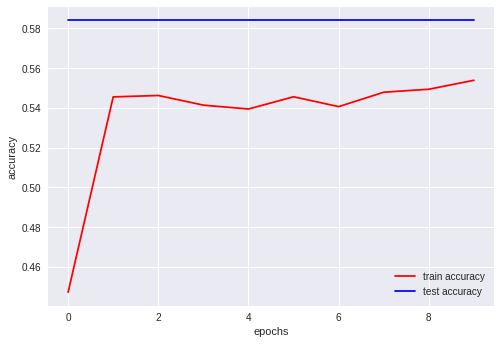

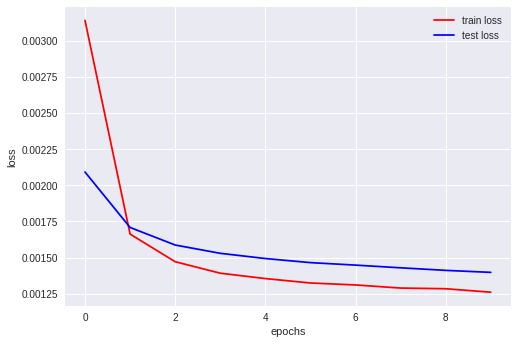

In [24]:
epochs = np.arange(10)
plt.plot(epochs, train_acc, color='r', label='train accuracy')
plt.plot(epochs, test_acc, color='b', label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.plot(epochs, train_loss, color='r', label='train loss')
plt.plot(epochs, test_loss, color='b', label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


Show three example results of your trained model on the validation set of the COCO dataset. More specifically show the top ten predicted categories along with the score for each for three sample images.

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=21.62s)
creating index...
index created!


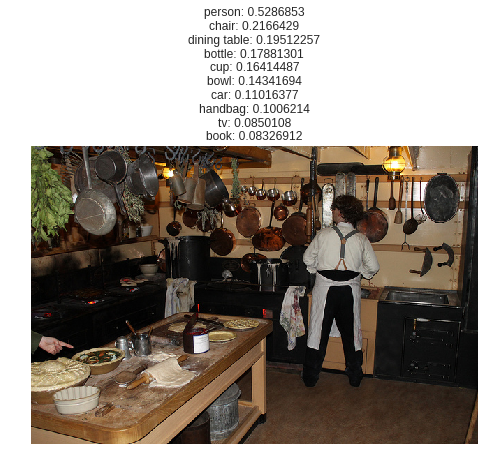

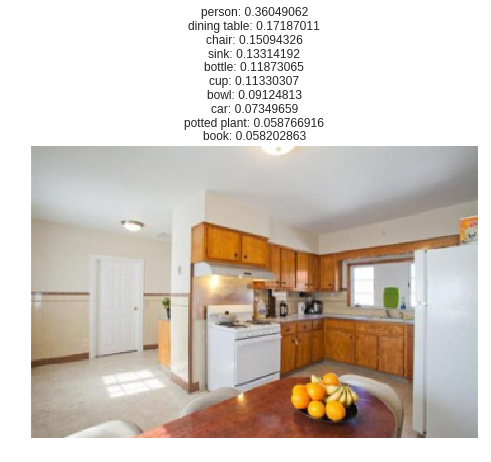

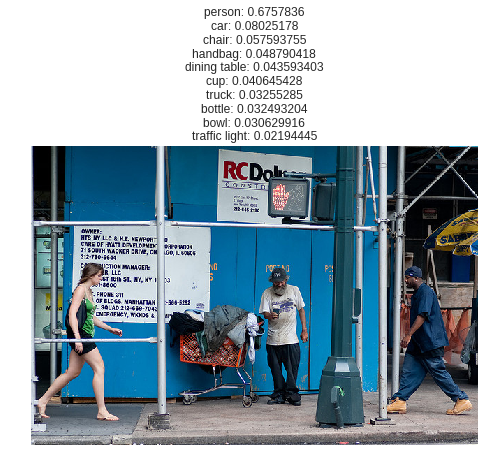

In [26]:
import torch.nn.functional as F

valid_data = datasets.CocoDetection('./val2017/',
           './annotations/instances_val2017.json', transform=transforms.ToTensor())
coco = COCO('./annotations/instances_train2017.json')
resnet = resnet.cpu()

for j in range(3):
  img = validation_data[j][0]
  img_view = valid_data[j][0]
  
  preds = resnet(Variable(img.unsqueeze(0)))

  # Highest probability is at index 0, but it's negative to easily sort
  probs, indices = (-F.sigmoid(preds).data).sort()

  # # Then we negate to get the pos prob again
  probs = (-probs).numpy()[0][:10]
  indices = indices.numpy()[0][:10]

  cat_ids = coco.getCatIds()
  cat_dict = {index: cat_id for index, cat_id in enumerate(cat_ids)}
  predicted_categories = coco.loadCats([cat_dict[i] for i in indices])
  pred_cats = [cat['name'] for cat in predicted_categories]

  pred_cats_and_probs = [str(item[0]) + ": " + str(item[1]) for item in zip(pred_cats, probs)]

  plt.figure()
  plt.title('\n'.join(pred_cats_and_probs))

  plt.imshow(np.transpose(img_view.numpy(), (1,2,0))); plt.grid('off'); plt.axis('off');
  

**Final Comments:** In this section you learned to use a very deep neural network that was trained to recognize 1000 categories, then you finetuned this network to another dataset that only had 80 categories, and for a different criterion (loss function). How would you measure the accuracy of this model?

### 4. Visual Recognition Open (6pts)
In this section implement any visual recognition application of your choice using data of your own choice. For instance you could train a Convolutional Neural Network on the Dogs vs Cats Kaggle competition dataset https://www.kaggle.com/c/dogs-vs-cats. The training data has 25,000 images, I already separated the images into training: 20,000 images and validation: 5,000 images. You can download the training, validation splits from the following dropbox link: [cats_dogs.zip](https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip). You will have to write your own dataset class inheriting from torch.utils.data.Dataset, and a model that trains on this dataset. As usual, include plots.

In [0]:
# Download and unzip the cats vs dgos dataset.
!wget -nc https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip
!unzip cats_dogs.zip

In [0]:
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import os
from PIL import Image
import numpy as np

class CatsDogsData(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    # list of all filenames in order
    self.all_files = sorted(os.listdir(root_dir))
    self.length = len(self.all_files)
    
  def __len__(self):
    return self.length
  
  def __getitem__(self, index):
    file_name = self.all_files[index]
    img_name = os.path.join(self.root_dir, file_name)
    img = Image.fromarray(io.imread(img_name))
    if self.transform:
      img = self.transform(img)

    # Assumes that file_names begin with either 'cat' or 'dog'
    # 0's are cats and 1's are dogs
    label=None
    if file_name[:3]=="cat":
      label=0
    else:
      label=1
    
    return [img, label]

    

In [34]:
from torchvision import models, transforms

preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

cat_dog_train = CatsDogsData("./trainset", transform=preprocessFn)
cat_dog_valid = CatsDogsData("./valset", transform=preprocessFn)

train_dataloader = DataLoader(cat_dog_train, batch_size=100,
                        shuffle=True, num_workers=0)

valid_dataloader = DataLoader(cat_dog_valid, batch_size=100,
                        shuffle=False, num_workers=0)

print(cat_dog_train[0][1])

0


In [0]:
from torch.autograd import Variable
from torch.utils.data import DataLoader
# from torch import from_numpy


def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):
  # Your code goes here.
  classifier = classifier.cuda()
  train_loss = np.zeros((n_epochs))
  train_acc = np.zeros((n_epochs))
  test_loss = np.zeros((n_epochs))
  test_acc = np.zeros((n_epochs))
  
  
  for epoch in range(0, n_epochs):
  
    correct = 0
    cumloss = 0
    # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
      classifier.train()
      # Flatten the images in the batch to input to the classifier.
      x = Variable(x.cuda())
      y = Variable(y.cuda())

      # Compute predictions under the current model.
      yhat = classifier(x)
#       print('X')
#       print(x.shape)
#       print('Y')
#       print(y.shape)
#       print('Y-hat')
#       print(yhat.shape)

      # Compute the loss with respect to this batch.
      loss = criterion(yhat, y)
      
      _, max_labels = yhat.data.max(1)
      correct += (max_labels == y.data).sum()

      # Set to zero gradients computed in previous iteration.
      optimizer.zero_grad()

      # Compute the gradients for the entire model variables,
      # this includes inputs, outputs, and parameters (weight, and bias).
      loss.backward()

      # Now we can update the weight and bias parameters.
      optimizer.step()

      cumloss += loss.data[0]

    print(epoch, 'training-loss: ', cumloss / 20000)
    print(epoch, 'training-accuracy: ', correct / 20000)
    train_loss[epoch] = cumloss / 20000
    train_acc[epoch] = correct / 20000

    correct = 0
    cumloss = 0

    classifier.eval()
    # Compute accuracy on the test set.
    for (i, (x, y)) in enumerate(valLoader):
      # Flatten the images in the batch to input to the classifier.
      x = Variable(x.cuda(), requires_grad = False)
      y = Variable(y.cuda(), requires_grad = False)

      # Compute predictions under the current model.
      yhat = classifier(x)
  
      _, max_labels = yhat.data.max(1)
      loss = criterion(yhat, y)

      correct += (max_labels == y.data).sum()
      cumloss += loss.data[0]
    test_loss[epoch] = cumloss / 5000
    test_acc[epoch] = correct / 5000

    print(epoch, 'validation-loss: ', cumloss / 5000)
    print(epoch, 'validation-accuracy: ', correct / 5000)
    print('\n')
  return train_loss, train_acc, test_loss, test_acc



In [0]:
    # Defining the model.
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# NikhilNet is a slight variation of LeNet classifier
class NikhilNetV2(nn.Module):
    def __init__(self):
        super(NikhilNetV2, self).__init__()
        
        # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.conv2 = nn.Conv2d(9, 32, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(32*53*53, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
#         print(out.shape)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Another linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)

        return out
        

In [45]:
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

cat_dog_train = CatsDogsData("./trainset", transform=preprocessFn)
cat_dog_valid = CatsDogsData("./valset", transform=preprocessFn)

train_dataloader = DataLoader(cat_dog_train, batch_size=100,
                        shuffle=True, num_workers=0)

valid_dataloader = DataLoader(cat_dog_valid, batch_size=100,
                        shuffle=False, num_workers=0)

classifier = NikhilNetV2()
criterion = nn.CrossEntropyLoss()
learningRate = 1e-2  
optimizer = optim.SGD(classifier.parameters(), lr = learningRate)

train_loss, train_acc, test_loss, test_acc = train_model(classifier, criterion, optimizer, 
            train_dataloader, valid_dataloader, n_epochs = 10)

print("Final test accuracy is:", test_acc[-1])

0 training-loss:  0.006786383244395256
0 training-accuracy:  0.56895
0 validation-loss:  0.006593876612186432
0 validation-accuracy:  0.6008


1 training-loss:  0.0064263221025466916
1 training-accuracy:  0.62895
1 validation-loss:  0.0062413469076156615
1 validation-accuracy:  0.6492


2 training-loss:  0.006147106695175171
2 training-accuracy:  0.65945
2 validation-loss:  0.006040224707126617
2 validation-accuracy:  0.665


3 training-loss:  0.005899402518570423
3 training-accuracy:  0.6833
3 validation-loss:  0.005806878143548966
3 validation-accuracy:  0.691


4 training-loss:  0.005679697333276272
4 training-accuracy:  0.70365
4 validation-loss:  0.005702830988168716
4 validation-accuracy:  0.701


5 training-loss:  0.005472373025119305
5 training-accuracy:  0.7228
5 validation-loss:  0.005564881771802902
5 validation-accuracy:  0.7148


6 training-loss:  0.005230145691335201
6 training-accuracy:  0.7414
6 validation-loss:  0.00535138458609581
6 validation-accuracy:  0.7458


7 tr

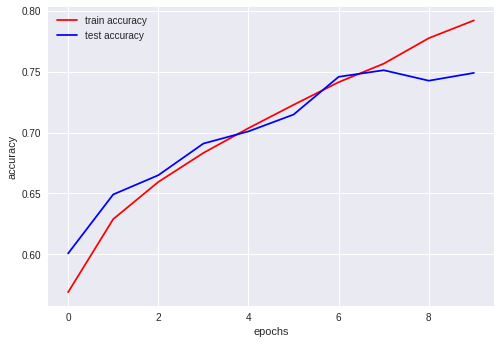

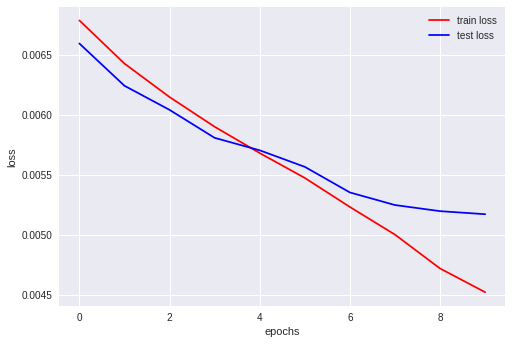

In [46]:
epochs = np.arange(10)
plt.plot(epochs, train_acc, color='r', label='train accuracy')
plt.plot(epochs, test_acc, color='b', label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.plot(epochs, train_loss, color='r', label='train loss')
plt.plot(epochs, test_loss, color='b', label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


**Final Comments:** If you didn't work in the dogs vs cats dataset, does your task affect people directly? Could your task cause any harm or unfairness to end users of your application? These are questions you should be asking yourself. Finally, I hope you enjoyed the Introduction to Computer Vision class this semester!